# Plan

Plan: 
Build a recommender system for recommending books from goodreads, using the following datasets:


`- 5.4.1.books-ratings.csv`


`- 5.4.1.books-info.csv`


# Load the libraries and the data

In [1]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [41]:
ratings = pd.read_csv("../../datasets/5.4.1.books-ratings.csv")
ratings

,book_id,user_id,rating
0,1,314,5
1,1,439,3
2,1,588,5
3,1,1169,4
4,1,1185,4
...,...,...,...
981751,10000,48386,5
981752,10000,49007,4
981753,10000,49383,5
981754,10000,50124,5


In [42]:
info = pd.read_csv("../../datasets/5.4.1.books-info.csv")
info

,Unnamed: 0,book_id,title
0,0,1,"The Hunger Games (The Hunger Games, #1)"
1,1,2,Harry Potter and the Sorcerer's Stone (Harry P...
2,2,3,"Twilight (Twilight, #1)"
3,3,4,To Kill a Mockingbird
4,4,5,The Great Gatsby
...,...,...,...
9995,9995,9996,"Bayou Moon (The Edge, #2)"
9996,9996,9997,"Means of Ascent (The Years of Lyndon Johnson, #2)"
9997,9997,9998,The Mauritius Command
9998,9998,9999,Cinderella Ate My Daughter: Dispatches from th...


In [43]:
info.drop(["Unnamed: 0"], axis=1, inplace=True)

In [44]:
info

,book_id,title
0,1,"The Hunger Games (The Hunger Games, #1)"
1,2,Harry Potter and the Sorcerer's Stone (Harry P...
2,3,"Twilight (Twilight, #1)"
3,4,To Kill a Mockingbird
4,5,The Great Gatsby
...,...,...
9995,9996,"Bayou Moon (The Edge, #2)"
9996,9997,"Means of Ascent (The Years of Lyndon Johnson, #2)"
9997,9998,The Mauritius Command
9998,9999,Cinderella Ate My Daughter: Dispatches from th...


In [45]:
ratings.columns

Index(['book_id', 'user_id', 'rating'], dtype='object')

In [46]:
info.columns

Index(['book_id', 'title'], dtype='object')

# Exploratory Analysis

In [47]:
# number of users

ratings.user_id.nunique()

53424

In [48]:
# number of books
info.book_id.nunique()

10000

In [49]:
# number of ratings per user
userfreq = ratings[["user_id", "book_id"]].groupby("user_id").count().reset_index()
userfreq.columns = ["user_id","no_ratings"]
userfreq.sort_values(by="no_ratings")

,user_id,no_ratings
9252,9253,2
28672,28673,2
42221,42222,2
21322,21323,2
42218,42219,2
...,...,...
28157,28158,199
12380,12381,199
52035,52036,199
30943,30944,200


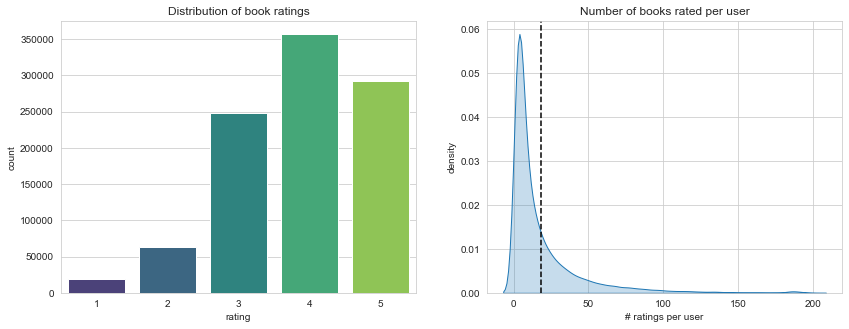

In [50]:
# look at the distrivbution of the ratings

sns.set_style("whitegrid")
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
ax = sns.countplot(x="rating", data=ratings, palette="viridis")
plt.title("Distribution of book ratings")

plt.subplot(1,2,2)
ax = sns.kdeplot(userfreq['no_ratings'], shade=True, legend=False)
plt.axvline(userfreq['no_ratings'].mean(), color="k", linestyle="--")
plt.xlabel("# ratings per user")
plt.ylabel("density")
plt.title("Number of books rated per user")
plt.show()


# Bahesian stats

In [51]:
bookstats = ratings.groupby("book_id")["rating"].agg(["count","mean"])
bookstats.head(5)

,count,mean
book_id,,
1,100,4.24
2,100,4.21
3,100,3.09
4,100,4.46
5,100,3.89


In [52]:
C=bookstats["count"].mean()
m=bookstats["mean"].mean()

In [53]:
def bayesian_avg(ratings):
    bayesian_avg = (C*m+ratings.sum()) / (C+ratings.count())
    return bayesian_avg

In [54]:
bayesavg_ratings = ratings.groupby("book_id")["rating"].agg(bayesian_avg).reset_index()
bayesavg_ratings.columns = ["book_id","bayesian_avg"]
bayesavg_ratings.head(5)

,book_id,bayesian_avg
0,1,4.050300
1,2,4.035161
2,3,3.470006
3,4,4.161312
4,5,3.873688


In [55]:
bookstats = bookstats.merge(bayesavg_ratings, on="book_id")
bookstats.head(5)

,book_id,count,mean,bayesian_avg
0,1,100,4.24,4.050300
1,2,100,4.21,4.035161
2,3,100,3.09,3.470006
3,4,100,4.46,4.161312
4,5,100,3.89,3.873688


In [56]:
bookstats = bookstats.merge(info[["book_id","title"]])
bookstats.head(5)

,book_id,count,mean,bayesian_avg,title
0,1,100,4.24,4.050300,"The Hunger Games (The Hunger Games, #1)"
1,2,100,4.21,4.035161,Harry Potter and the Sorcerer's Stone (Harry P...
2,3,100,3.09,3.470006,"Twilight (Twilight, #1)"
3,4,100,4.46,4.161312,To Kill a Mockingbird
4,5,100,3.89,3.873688,The Great Gatsby


# Building the recommender system

## Dictionaries

In [57]:
booktitles = dict(zip(info["book_id"], info["title"]))
booktitles

{1: 'The Hunger Games (The Hunger Games, #1)',
 2: "Harry Potter and the Sorcerer's Stone (Harry Potter, #1)",
 3: 'Twilight (Twilight, #1)',
 4: 'To Kill a Mockingbird',
 5: 'The Great Gatsby',
 6: 'The Fault in Our Stars',
 7: 'The Hobbit',
 8: 'The Catcher in the Rye',
 9: 'Angels & Demons  (Robert Langdon, #1)',
 10: 'Pride and Prejudice',
 11: 'The Kite Runner',
 12: 'Divergent (Divergent, #1)',
 13: '1984',
 14: 'Animal Farm',
 15: 'The Diary of a Young Girl',
 16: 'The Girl with the Dragon Tattoo (Millennium, #1)',
 17: 'Catching Fire (The Hunger Games, #2)',
 18: 'Harry Potter and the Prisoner of Azkaban (Harry Potter, #3)',
 19: 'The Fellowship of the Ring (The Lord of the Rings, #1)',
 20: 'Mockingjay (The Hunger Games, #3)',
 21: 'Harry Potter and the Order of the Phoenix (Harry Potter, #5)',
 22: 'The Lovely Bones',
 23: 'Harry Potter and the Chamber of Secrets (Harry Potter, #2)',
 24: 'Harry Potter and the Goblet of Fire (Harry Potter, #4)',
 25: 'Harry Potter and the Dea

## The matrix

In [58]:
from scipy.sparse import csr_matrix

def create_X(df):
    """
    Generates a sparse matrix from ratings dataframe.
    
    Args:
        df: pandas dataframe
    
    Returns:
        X: sparse matrix
        user_mapper: dict that maps user id's to user indices
        user_inv_mapper: dict that maps user indices to user id's
        movie_mapper: dict that maps movie id's to movie indices
        movie_inv_mapper: dict that maps movie indices to movie id's
    """
    
    N = df["user_id"].nunique() # number of users
    M= df["book_id"].nunique() # number of books
    
    user_mapper = dict(zip(np.unique(df["user_id"]), list(range(N))))
    book_mapper = dict(zip(np.unique(df["book_id"]), list(range(M))))
    
    user_inv_mapper = dict(zip(list(range(N)), np.unique(df["user_id"])))
    book_inv_mapper = dict(zip(list(range(M)), np.unique(df["book_id"])))
    
    user_index = [user_mapper[i] for i in df["user_id"]]
    book_index = [book_mapper[i] for i in df["book_id"]]
    
    X = csr_matrix((df["rating"], (book_index, user_index)), shape=(M,N))
    
    return X, user_mapper, book_mapper, user_inv_mapper, book_inv_mapper

In [59]:
# actually creating the matrix

X, user_mapper, book_mapper, user_inv_mapper, book_inv_mapper = create_X(ratings)

In [60]:
X

<10000x53424 sparse matrix of type '<class 'numpy.int64'>'
	with 979478 stored elements in Compressed Sparse Row format>

In [61]:
# turn to sparse matrix into dataframe

usermatrix = pd.DataFrame(X.todense(), index=ratings.book_id.unique(), columns = ratings.user_id.unique())
usermatrix

,314,439,588,1169,1185,2077,2487,2900,3662,3922,...,43460,8367,29358,2153,3133,29736,18936,43623,24406,27590
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9999,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [62]:
# calculate the sparsity of our matrix

sparsity = X.count_nonzero()/(X.shape[0]*X.shape[1])

print("The sparsity of this matrix is ", round(sparsity*100,2))

The sparsity of this matrix is  0.18


## k-nearest neighbors

In [63]:
from sklearn.neighbors import NearestNeighbors

KNN = NearestNeighbors(n_neighbors=10, metric="cosine") 
KNN.fit(X)

NearestNeighbors(metric='cosine', n_neighbors=10)

In [64]:
# use the mapper to find the index of the book we want to assess

bookindex = book_mapper[10]
bookindex

9

In [65]:
book_toassess = X[9]
book_toassess

<1x53424 sparse matrix of type '<class 'numpy.int64'>'
	with 100 stored elements in Compressed Sparse Row format>

In [66]:
# find the nearest neighbors to this book
neig = KNN.kneighbors(book_toassess, return_distance=False)
neig

array([[ 9, 42, 12, 75, 32,  7,  3, 62, 13,  4]], dtype=int64)

In [67]:
# use the inverse mapper to find the ids of the neighbours

neig_ids = []
for i in range(1,10):
    n = neig.item(i)
    neig_ids.append(book_inv_mapper[n])

In [68]:
neig_ids

[43, 13, 76, 33, 8, 4, 63, 14, 5]

In [69]:
# use the ids to find the titles

print("because you enjoyed reading:",booktitles[9])
for i in neig_ids:
    print(booktitles[i])

because you enjoyed reading: Angels & Demons  (Robert Langdon, #1)
Jane Eyre
1984
Sense and Sensibility
Memoirs of a Geisha
The Catcher in the Rye
To Kill a Mockingbird
Wuthering Heights
Animal Farm
The Great Gatsby


## Make a recommender function

In [70]:
def rec_books(book_id, df, X, k, metric="cosine"):
    """
    Finds k-nearest neighbours for a given book id.
    
    Args:
        book_id: id of the book of interest
        X: user-item utility matrix
        k: number of similar book to retrieve
        metric: distance metric for kNN calculations
    
    Returns:
        list of k similar book ID's
    """
        
    neighbour_ids = []
        
    book_ind = book_mapper[book_id]
    book_to_assess = X[book_ind]
    KNN = NearestNeighbors(n_neighbors=k, metric=metric)
        
    KNN.fit(X)
        
    neighbour = KNN.kneighbors(book_to_assess, return_distance=False)
        
    for i in range(1,k):
        n = neighbour.item(i)
        neighbour_ids.append(book_inv_mapper[n])
            
    book_titles = dict(zip(df["book_id"], df["title"]))
    book_title = book_titles[book_id]
        
    print("Because you enjoyed reading:", book_title, ", I think you would enjoy these:")
    for i in neighbour_ids:
        print(book_titles[i])

In [71]:
info[info.title.str.contains('Potter')]

,book_id,title
1,2,Harry Potter and the Sorcerer's Stone (Harry P...
17,18,Harry Potter and the Prisoner of Azkaban (Harr...
20,21,Harry Potter and the Order of the Phoenix (Har...
22,23,Harry Potter and the Chamber of Secrets (Harry...
23,24,Harry Potter and the Goblet of Fire (Harry Pot...
24,25,Harry Potter and the Deathly Hallows (Harry Po...
26,27,Harry Potter and the Half-Blood Prince (Harry ...
278,279,Harry Potter and the Cursed Child - Parts One ...
421,422,"Harry Potter Boxset (Harry Potter, #1-7)"
2000,2001,Harry Potter: Film Wizardry


In [72]:
rec_books(2, info, X, k=10)

Because you enjoyed reading: Harry Potter and the Sorcerer's Stone (Harry Potter, #1) , I think you would enjoy these:
To Kill a Mockingbird
Memoirs of a Geisha
1984
The Great Gatsby
The Fellowship of the Ring (The Lord of the Rings, #1)
Lord of the Flies
Harry Potter and the Prisoner of Azkaban (Harry Potter, #3)
The Hobbit
The Diary of a Young Girl


In [73]:
info[info.title.str.contains('Mistborn')]

,book_id,title
388,389,"The Final Empire (Mistborn, #1)"
564,565,"The Well of Ascension (Mistborn, #2)"
602,603,"The Hero of Ages (Mistborn, #3)"
1199,1200,"The Alloy of Law (Mistborn, #4)"
2791,2792,"Shadows of Self (Mistborn, #5)"
2888,2889,"Mistborn Trilogy Boxed Set (Mistborn, #1-3)"
3340,3341,"The Bands of Mourning (Mistborn, #6)"
7992,7993,"Secret History (Mistborn, #3.5)"


In [74]:
rec_books(389, info, X, k=10)

Because you enjoyed reading: The Final Empire (Mistborn, #1) , I think you would enjoy these:
The Well of Ascension (Mistborn, #2)
The Hero of Ages (Mistborn, #3)
The Way of Kings (The Stormlight Archive, #1)
The Alloy of Law (Mistborn, #4)
Elantris (Elantris, #1)
The Dragon Reborn (Wheel of Time, #3)
The Wise Man's Fear (The Kingkiller Chronicle, #2)
The Gathering Storm (Wheel of Time, #12)
Assassin's Apprentice (Farseer Trilogy, #1)


In [75]:
info[info.title.str.contains('Way of Kings')]

,book_id,title
561,562,"The Way of Kings (The Stormlight Archive, #1)"
9140,9141,"The Way of Kings, Part 1 (The Stormlight Archi..."


In [76]:
rec_books(562, info, X, k=10)

Because you enjoyed reading: The Way of Kings (The Stormlight Archive, #1) , I think you would enjoy these:
The Hero of Ages (Mistborn, #3)
The Well of Ascension (Mistborn, #2)
The Final Empire (Mistborn, #1)
Words of Radiance (The Stormlight Archive, #2)
The Alloy of Law (Mistborn, #4)
The Gathering Storm (Wheel of Time, #12)
Towers of Midnight (Wheel of Time, #13)
The Wise Man's Fear (The Kingkiller Chronicle, #2)
The Lies of Locke Lamora (Gentleman Bastard, #1)


In [77]:
rec_books(9141, info, X, k=10)

Because you enjoyed reading: The Way of Kings, Part 1 (The Stormlight Archive #1.1) , I think you would enjoy these:
The Wheel of Time: Boxed Set #1 (Wheel of Time, #1-3)
Legion (Legion, #1)
Skin Deep (Legion, #2)
The Emperor's Soul
Mistborn Trilogy Boxed Set (Mistborn, #1-3)
The Farseer Trilogy (Farseer Trilogy #1-3)
Alcatraz Versus the Evil Librarians (Alcatraz, #1)
The Rithmatist (The Rithmatist, #1)
The Night Angel Trilogy (Night Angel, #1-3)
